In [61]:
from amplpy import AMPL

ampl = AMPL()
ampl.read("proj3.mod")
ampl.read_data("proj3.dat")

In [62]:
import pandas as pd


def solve(
    ampl: AMPL,
    epsilon: float = 0.000001,
    beta: float = 0.1,
    aspiration_cost: float = 0,
    aspiration_satisfaction: float = 0,
    lambda_cost: float = 1,
    lambda_satisfaction: float = 10000,
):
    targets = ["cost", "satisfaction"]
    ampl.param["EPSILON"] = epsilon
    ampl.param["BETA"] = beta
    ampl.param["ASPIRATION"] = pd.DataFrame([aspiration_cost, aspiration_satisfaction], index=targets)
    ampl.param["LAMBDA"] = pd.DataFrame([lambda_cost, lambda_satisfaction], index=targets)

    ampl.solve(solver="cplex", verbose=False)
    assert ampl.solve_result == "solved"

In [63]:
solve(
    ampl,
    aspiration_cost=200,
    aspiration_satisfaction=3,
    lambda_cost=1,
    lambda_satisfaction=10000,
)

print("objective:", ampl.get_current_objective().value())

objective: -199880.0


In [64]:
from dataclasses import dataclass
from IPython.display import HTML

from io import StringIO


def display_html_flex(*children: list[str]):
    buff = StringIO()
    buff.write('<div style="display:flex;gap:2em;">')
    for child in children:
        buff.write(child)
    buff.write("</div>")
    buff.seek(0)
    display(HTML(buff.read()))


@dataclass
class Result:
    flow: pd.DataFrame
    satisfaction: pd.DataFrame
    total_cost: float

    @property
    def total_satisfaction(self):
        return self.satisfaction.values.sum()

    @property
    def stats(self):
        return pd.DataFrame(
            [self.total_cost, self.total_satisfaction],
            index=["total_cost", "total_satisfaction"],
            columns=["stats"]
        )

    def _ipython_display_(self):
        display_html_flex(
            self.stats.to_html(), self.flow.to_html(), self.satisfaction.to_html()
        )

def key_to_position_tuple(key: str) -> tuple[int, int]:
    first =  {"M": 1, "K": 2}[key[0]]
    second =  key[1]
    return (first, second)


def get_result(ampl: AMPL) -> Result:
    flow = ampl.get_data("flow").to_pandas()
    flow = flow.set_index(flow.index.set_names(["source", "dest"])).unstack("source")
    flow = flow.sort_index(key=lambda x: x.to_series().apply(key_to_position_tuple))

    satisfaction = ampl.get_data("satisfaction").to_pandas()

    total_cost = ampl.get_value("total_cost")

    return Result(flow=flow, satisfaction=satisfaction, total_cost=total_cost)

In [65]:
get_result(ampl)

In [66]:
from functools import wraps

@wraps(solve)
def run(ampl: AMPL, *args, **kwargs) -> Result:
    solve(ampl, *args, **kwargs)
    return get_result(ampl)

In [67]:
result_cost = run(ampl, aspiration_satisfaction=0, aspiration_cost=0)
result_cost

In [68]:
result_satisfaction = run(ampl, aspiration_satisfaction=5, aspiration_cost=1e6)
result_satisfaction

In [69]:
import numpy as np

cost_aspirations = np.linspace(
    result_cost.total_cost, result_satisfaction.total_cost, 50
)

satisfaction_aspirations = np.linspace(
    result_cost.total_satisfaction, result_satisfaction.total_satisfaction, 50
)

results = [
    run(
        ampl,
        aspiration_satisfaction=satisfaction,
        aspiration_cost=cost,
    )
    for cost, satisfaction in zip(cost_aspirations, satisfaction_aspirations)
]

effective = pd.DataFrame(
    {
        "a_cost": cost_aspirations,
        "a_satisfaction": satisfaction_aspirations,
        "cost": np.array([result.total_cost for result in results]),
        "satisfaction": np.array([result.total_satisfaction for result in results]),
    }
)
effective.round({"a_cost": 0, "a_satisfaction": 2, "cost": 0, "satisfaction": 2}).set_index(["a_cost", "a_satisfaction"])

,,cost,satisfaction
a_cost,a_satisfaction,,
181000.0,2.00,181000.0,2.00
181898.0,2.06,181566.0,2.09
182796.0,2.12,182133.0,2.19
183694.0,2.18,182699.0,2.28
184592.0,2.24,183265.0,2.38
185490.0,2.31,183832.0,2.47
186388.0,2.37,184398.0,2.57
187286.0,2.43,184964.0,2.66
188184.0,2.49,185531.0,2.76


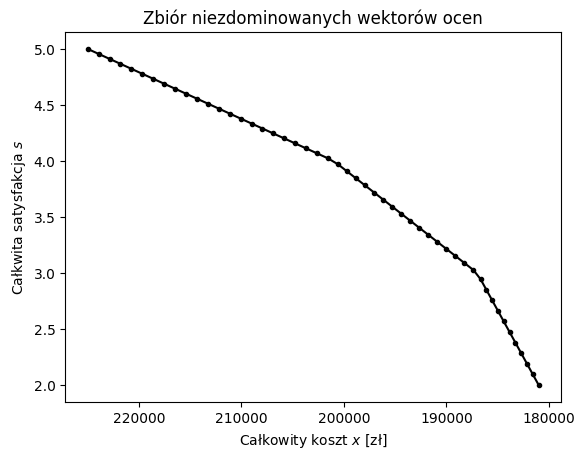

In [70]:
from matplotlib import pyplot as plt

effective_costs = np.array([result.total_cost for result in results])
effective_satisfactions = np.array([result.total_satisfaction for result in results])

plt.plot(effective_costs, effective_satisfactions, "ko-", markersize=3)
plt.subplot().invert_xaxis()
plt.title("Zbiór niezdominowanych wektorów ocen")
plt.xlabel("Całkowity koszt $x$ [zł]")
plt.ylabel("Całkwita satysfakcja $s$")
plt.savefig("../out/proj3-effective.png")
plt.show()

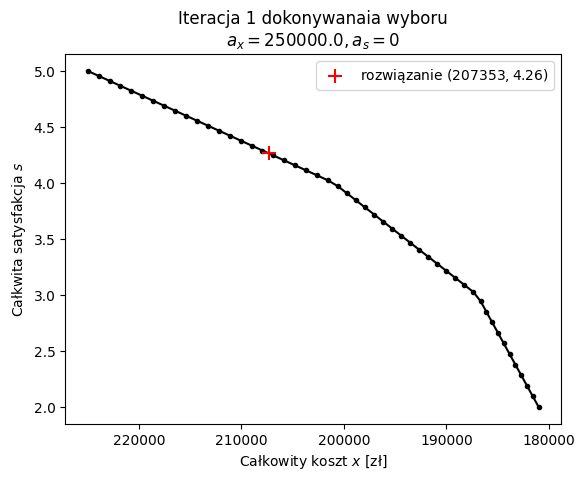

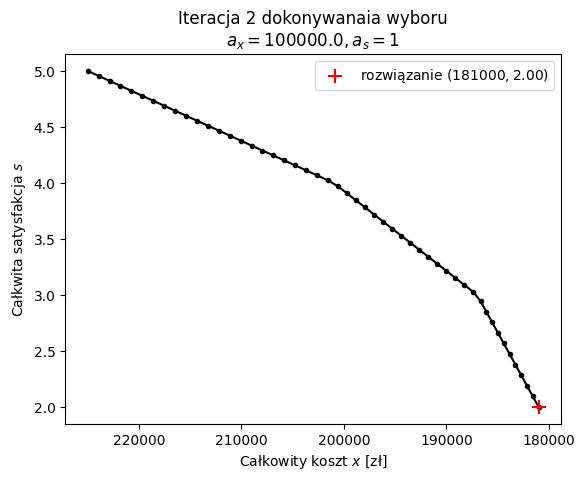

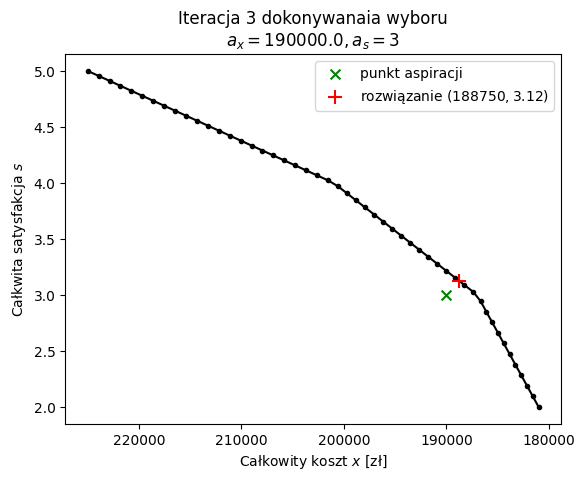

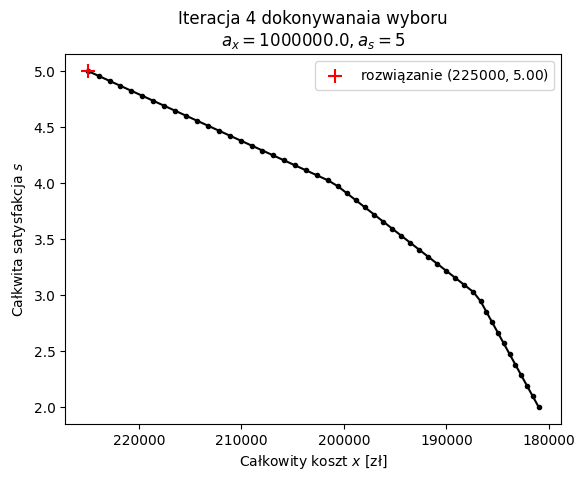

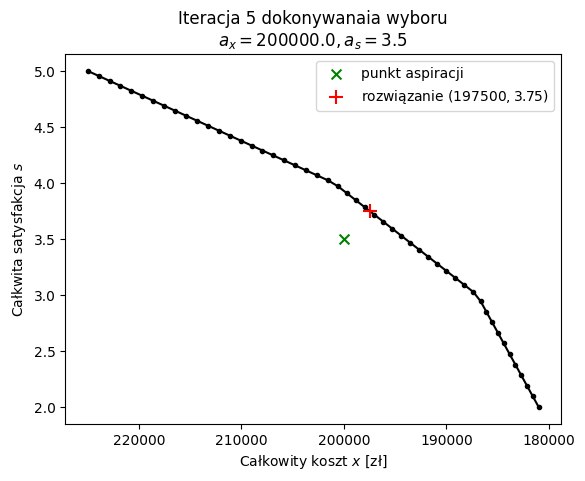

In [79]:
cost_min = effective_costs.min()
cost_max = effective_costs.max()
satisfaction_min = effective_satisfactions.min()
satisfaction_max = effective_satisfactions.max()


@wraps(solve)
def decide_iteration(i: int, *args, aspiration_cost, aspiration_satisfaction, **kwargs):
    result = run(
        *args,
        aspiration_cost=aspiration_cost,
        aspiration_satisfaction=aspiration_satisfaction,
        **kwargs,
    )

    cost_in_range = aspiration_cost >= cost_min and aspiration_cost <= cost_max
    satisfaction_in_range = (
        aspiration_satisfaction >= satisfaction_min
        and aspiration_satisfaction <= satisfaction_max
    )

    plt.plot(effective_costs, effective_satisfactions, "ko-", markersize=3, zorder=1)
    if cost_in_range and satisfaction_in_range:
        plt.scatter(
            aspiration_cost,
            aspiration_satisfaction,
            c="g",
            marker="x",
            s=50,
            zorder=2,
            label="punkt aspiracji",
        )
    plt.scatter(
        result.total_cost,
        result.total_satisfaction,
        c="r",
        marker="+",
        s=100,
        zorder=3,
        label=f"rozwiązanie $({result.total_cost:.0f}, {result.total_satisfaction:.2f})$",
    )

    plt.subplot().invert_xaxis()
    plt.title(
        f"Iteracja {i} dokonywanaia wyboru\n"
        f"$a_x = {aspiration_cost}, a_s = {aspiration_satisfaction}$"
    )
    plt.xlabel("Całkowity koszt $x$ [zł]")
    plt.ylabel("Całkwita satysfakcja $s$")
    plt.legend()
    plt.savefig(f"../out/proj3-decision-{i}.png")
    plt.show()


decide_iteration(1, ampl, aspiration_cost=250e3, aspiration_satisfaction=0)
decide_iteration(2, ampl, aspiration_cost=100e3, aspiration_satisfaction=1)
decide_iteration(3, ampl, aspiration_cost=190e3, aspiration_satisfaction=3)
decide_iteration(4, ampl, aspiration_cost=1000e3, aspiration_satisfaction=5)
decide_iteration(5, ampl, aspiration_cost=200e3, aspiration_satisfaction=3.5)